<a href="https://colab.research.google.com/github/SOUMEE2000/Machine-Learning-Stash/blob/main/Image%20Processing%20Basics/Dendritic_Spine_Segmentation(Attention%20U_Net).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install focal_loss

# **On Drive Dataset**

In [2]:
from keras.layers import *
from keras.models  import *
from keras.optimizers import *
import keras.backend as K
import numpy as np 
import os
import skimage.io as io
import cv2
import tensorflow as tf


In [3]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = tf.keras.layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = tf.keras.layers.BatchNormalization(axis=3)(conv)
    conv = tf.keras.layers.Activation("relu")(conv)

    conv = tf.keras.layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = tf.keras.layers.BatchNormalization(axis=3)(conv)
    conv = tf.keras.layers.Activation("relu")(conv)
    
    if dropout > 0:
        conv = tf.keras.layers.Dropout(dropout)(conv)

    return conv

In [4]:
def gating_signal(input, out_size, batch_norm=False):
    """
    resize the down layer feature map into the same dimension as the up layer feature map
    using 1x1 conv
    :return: the gating feature map with the same dimension of the up layer feature map
    """
    x = tf.keras.layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

# Getting the x signal to the same shape as the gating signal
    theta_x = tf.keras.layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

# Getting the gating signal to the same number of filters as the inter_shape
    phi_g = tf.keras.layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = tf.keras.layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = tf.keras.layers.add([upsample_g, theta_x])
    act_xg = tf.keras.layers.Activation('relu')(concat_xg)
    psi = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = tf.keras.layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = tf.keras.layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = repeat_elem(upsample_psi, shape_x[3])

    y = tf.keras.layers.multiply([upsample_psi, x])

    result = tf.keras.layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = tf.keras.layers.BatchNormalization()(result)
    return result_bn

def repeat_elem(tensor, rep):
    # lambda function to repeat Repeats the elements of a tensor along an axis
    #by a factor of rep.
    # If tensor has shape (None, 256,256,3), lambda will return a tensor of shape 
    #(None, 256,256,6), if specified axis=3 and rep=2.

     return tf.keras.layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [32]:
def Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.2, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    inputs = tf.keras.layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # DownRes 1, convolution + pooling
    conv_128 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = conv_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = conv_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = conv_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = conv_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = tf.keras.layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = tf.keras.layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = tf.keras.layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = tf.keras.layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = tf.keras.layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = tf.keras.layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = tf.keras.layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = tf.keras.layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = tf.keras.layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = tf.keras.layers.BatchNormalization(axis=3)(conv_final)
    conv_final = tf.keras.layers.Activation('sigmoid')(conv_final)  #Change to softmax for multichannel

    # Model integration
    model = Model(inputs, conv_final, name="Attention_UNet")
    model.summary()
    return model

In [97]:
from focal_loss import *

input_shape = (256, 256, 1)
att_unet_model = Attention_UNet(input_shape)

adam = Adam(0.0001)
att_unet_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


Model: "Attention_UNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Total params: 37,333,513
Trainable params: 37,317,895
Non-trainable params: 15,618
__________________________________________________________________________________________________


In [7]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Datasets/DRIVE.zip"
with ZipFile(file_name,'r') as zipf:
  zipf.extractall()
  print('finish')

finish


In [8]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Datasets/Modified_drive.zip"
with ZipFile(file_name,'r') as zipf:
  zipf.extractall()
  print('finish')

finish


In [9]:
import os

import cv2
from keras.callbacks import TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import keras.backend as K
#import  scipy.misc.pilutil
data_location = ''

training_loc= "/content/Modified_drive/"
training_label_loc= "/content/DRIVE/training/1st_manual/"
#training_loc_mask= "/content/DRIVE/training/mask/"

training_images= os.listdir(training_loc)
training_labels= os.listdir(training_label_loc)
#training_masks= os.listdir(training_loc_mask)

training_images.sort()
training_labels.sort()


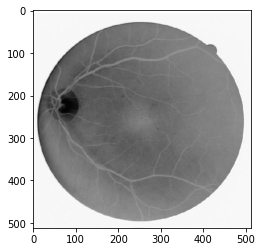

In [15]:
import matplotlib.pyplot as plt
img = plt.imread("/content/Modified_drive/21_training.jpg")
plt.imshow(img, cmap = "gray")

In [16]:
def changing_intensity(img):
  for i in range(len(img)):
    for j in range(len(img)):
      if img[i][j] > 200:
        img[i][j] = 0
  
  return img

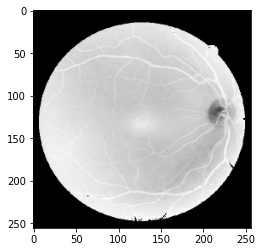

In [17]:
train_data = []
train_label = []
desired_size = 256

for i in training_images:
    im = plt.imread(training_loc + "/" + i)
    im = np.array(im)
    im =  changing_intensity(im)
    #plt.imsave( "/content/test/" + str(i) + ".png", im)
    label = plt.imread(training_label_loc + i.split('_')[0] + '_manual1.gif')
    im = cv2.resize(im, (desired_size, desired_size))
    plt.imshow(im, cmap ="gray")
    train_data.append(im)
    temp = cv2.resize(label, (desired_size, desired_size))
    train_label.append(temp)

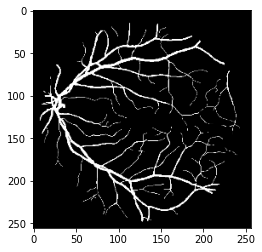

In [19]:
plt.imshow(train_label[0], cmap = "gray")

In [20]:
train_label = np.array(train_label)
train_label = np.reshape(train_label, (20,desired_size, desired_size,1))
train_data = np.array(train_data)
train_data = np.reshape(train_data, (20,desired_size, desired_size,1))

In [22]:
train_label.max()

255

In [23]:
x_train = train_data.astype('float32') / 255.
y_train = train_label.astype('float32')/255

In [34]:
att_unet_history = att_unet_model.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = 5,
                    shuffle=False,
                    epochs=1000)



Epoch 1/1000
4/4 [==============================] - 7s 410ms/step - loss: 0.6872 - accuracy: 0.8432
Epoch 2/1000
4/4 [==============================] - 2s 409ms/step - loss: 0.6290 - accuracy: 0.8791
Epoch 3/1000
4/4 [==============================] - 2s 408ms/step - loss: 0.4475 - accuracy: 0.8791
Epoch 4/1000
4/4 [==============================] - 2s 408ms/step - loss: 0.4188 - accuracy: 0.8791
Epoch 5/1000
4/4 [==============================] - 2s 411ms/step - loss: 0.3741 - accuracy: 0.8791
Epoch 6/1000
4/4 [==============================] - 2s 414ms/step - loss: 0.3445 - accuracy: 0.8791
Epoch 7/1000
4/4 [==============================] - 2s 413ms/step - loss: 0.3222 - accuracy: 0.8791
Epoch 8/1000
4/4 [==============================] - 2s 414ms/step - loss: 0.3001 - accuracy: 0.8791
Epoch 9/1000
4/4 [==============================] - 2s 414ms/step - loss: 0.2888 - accuracy: 0.8791
Epoch 10/1000
4/4 [==============================] - 2s 415ms/step - loss: 0.2785 - accuracy: 0.8791

In [72]:
test_images_loc = "/content/drive/MyDrive/09112015_5-CT2_czas_przed_do _20(3rd)/A"

test_files= os.listdir(test_images_loc)
test_files.sort()
test_data=[]
count = 0

for i in test_files:
  test_im= plt.imread(test_images_loc + '/' + i)
  #img_array = spilt_imgs(test_im[:, :, 0]) 
  #im = stitch_imgs(y_pred[...,0])
  test_data.append(cv2.resize(test_im[:,:,0],(desired_size, desired_size)))
  

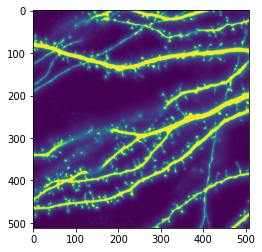

In [73]:
img = plt.imread("/content/drive/MyDrive/09112015_5-CT2_czas_przed_do _20(3rd)/A/MAX_09112015_5-CT2_czas_przed_do_20-0013.png")
plt.imshow(img[:,:,0])

In [74]:
img[:,:,0].shape

(512, 508)

In [77]:
test_data= np.array(test_data)
print(test_data.shape)
x_test = test_data
x_test = np.reshape(x_test, (len(x_test), desired_size, desired_size, 1))  # adapt this if using `channels_first` image data format
y_pred= att_unet_model.predict(x_test)

(6, 256, 256)


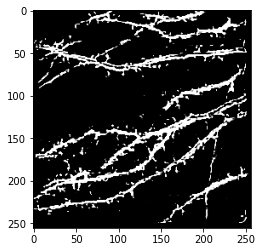

In [80]:
plt.imshow(y_pred[0,...,0], cmap ="gray")

# **On Dendritic Spines**

In [84]:
import tifffile as tif
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import gaussian
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)
from skimage import data, color, io, img_as_float
def get_mip(img):
    return np.amax(img,0)

def get_binary_output(img,val = 1):

    # Gaussian Filter:
    img_g = gaussian(img,2)
    
    if val == 0:
        # Generating MIP from the given image:
        new_image = get_mip(img_g)
#         # Getting useful data:
#         new_image = (_image>0.1)*_image
        
    else:
        new_image = img_g
    
    if len(np.unique(new_image))==1:
        img_fin = np.full((img.shape[1],img.shape[2]),np.max(np.unique(new_image)))
        return img_fin
    
    # Applying Algorithms to get the final binary images:
    window_size = 41
    thresh_niblack = threshold_niblack(new_image, window_size=window_size, k=0.0001)
    thresh_sauvola = threshold_sauvola(new_image, window_size=window_size)
    binary_niblack = new_image > thresh_niblack
    binary_sauvola = new_image > thresh_sauvola
    thresh = threshold_otsu(new_image)
    binary_otsu = new_image > thresh
    final_result = []
    img_new = []
#     print(binary_niblack.shape,new_image.shape)
#     return
    # Generating the Combinations of all images:
    bin_niblack = np.reshape(binary_niblack,(binary_niblack.shape[0],binary_niblack.shape[1],1))
    bin_sauvola = np.reshape(binary_sauvola,(binary_sauvola.shape[0],binary_sauvola.shape[1],1))
    bin_otsu = np.reshape(binary_otsu,(binary_otsu.shape[0],binary_otsu.shape[1],1))
    combo = np.append(bin_niblack,bin_sauvola,axis=2)
    combo = np.append(combo,bin_otsu,axis=2)
        
    # Voting for final Pixel Intensity:
    for i in range(binary_niblack.shape[0]):
        row = []
        for j in range(binary_niblack.shape[1]):
            tup = np.bincount(combo[i][j])
            if len(tup) == 1:
                row.append(False)
            elif len(tup == 2):
                if tup[0] > tup[1]:
                    row.append(False)
                else:
                    row.append(True)
        final_result.append(row)
    final_result = np.array(final_result)
    return final_result

def get_masked_image(img1,mask):
    w = mask.shape[0]
    h = mask.shape[1]
    img_stk = np.dstack((img1,img1,img1))
    img_stk2 = np.dstack((mask.astype("uint8")*255,np.zeros((w,h)).astype("uint8"),np.zeros((w,h)).astype("uint8")))
    alpha = 0.6
    img_hsv = color.rgb2hsv(img_stk)
    color_mask_hsv = color.rgb2hsv(img_stk2)
    img_hsv[..., 0] = color_mask_hsv[..., 0]
    img_hsv[..., 1] = color_mask_hsv[..., 1] * alpha
    img_masked = color.hsv2rgb(img_hsv)
    return (img_masked*255).astype("uint8")

def plot_image(img):
    plt.figure(figsize=(10,5)) 
    plt.imshow(img,cmap='gray')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

def gen_save_numpy(img1,img2,fname):
    img1 = np.reshape(img1,(img1.shape[0],img1.shape[1],1))
    img2 = np.reshape(img2,(img2.shape[0],img2.shape[1],1))
    fin_img = np.append(img1,img2,axis=2)
    with open(fname+".npy","wb") as f:
        np.save(f,fin_img)
    return fin_img

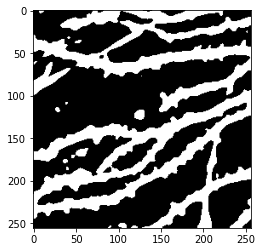

In [90]:
train_images_loc = "/content/drive/MyDrive/09112015_5-CT2_czas_przed_do _20(3rd)/A"

train_files= os.listdir(test_images_loc)
train_files.sort()
train_data=[]
train_label =[]
count = 0

for i in test_files:
  test_im= plt.imread(train_images_loc + '/' + i)
  #img_array = spilt_imgs(test_im[:, :, 0]) 
  #im = stitch_imgs(y_pred[...,0])
  img = cv2.resize(test_im[:,:,0],(desired_size, desired_size))
  train_data.append(img)
  img = get_binary_output(img)
  plt.imshow(img, cmap ="gray")
  train_label.append(img)

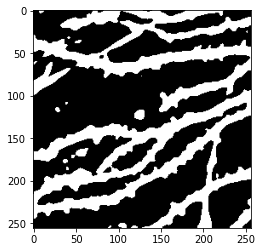

In [93]:
train_data = []
train_label = []
desired_size = 256

training_loc =  "/content/drive/MyDrive/09112015_5-CT2_czas_przed_do _20(3rd)/"
training_label_loc = "/content/Labels/"

train_A =  os.listdir(training_loc + "A")
train_B =  os.listdir(training_loc + "B")
train_C =  os.listdir(training_loc + "C")

train_A.sort()
train_B.sort()
train_C.sort()

for i in range(6):
  im = plt.imread(training_loc + "A/" + train_A[i])
  img = cv2.resize(im[:,:,0], (desired_size, desired_size))
  train_data.append(img)

  img = get_binary_output(img)
  plt.imshow(img, cmap ="gray")
  train_label.append(img)

  im = plt.imread(training_loc + "B/" + train_B[i])
  img = cv2.resize(im[:,:,0], (desired_size, desired_size))
  train_data.append(img)
  
  img = get_binary_output(img)
  train_label.append(img)
  
  im = plt.imread(training_loc + "C/" + train_C[i])
  img = cv2.resize(im[:,:,0], (desired_size, desired_size))
  train_data.append(img)
  
  img = get_binary_output(img)
  train_label.append(img)


In [94]:
train_label = np.array(train_label)
train_label = np.reshape(train_label, (18,desired_size, desired_size,1))
train_data = np.array(train_data)
train_data = np.reshape(train_data, (18,desired_size, desired_size,1))

In [98]:
att_unet_model.fit(train_data, train_label,
                    verbose=1,
                    batch_size = 6,
                    shuffle=False,
                    epochs=1000)


Epoch 1/1000
3/3 [==============================] - 11s 482ms/step - loss: 0.6916 - accuracy: 0.6587
Epoch 2/1000
3/3 [==============================] - 1s 480ms/step - loss: 0.6854 - accuracy: 0.9020
Epoch 3/1000
3/3 [==============================] - 1s 478ms/step - loss: 0.6667 - accuracy: 0.8228
Epoch 4/1000
3/3 [==============================] - 1s 481ms/step - loss: 0.6100 - accuracy: 0.7121
Epoch 5/1000
3/3 [==============================] - 1s 480ms/step - loss: 0.5855 - accuracy: 0.7989
Epoch 6/1000
3/3 [==============================] - 1s 482ms/step - loss: 0.4879 - accuracy: 0.8174
Epoch 7/1000
3/3 [==============================] - 1s 483ms/step - loss: 0.4181 - accuracy: 0.8166
Epoch 8/1000
3/3 [==============================] - 1s 482ms/step - loss: 0.3360 - accuracy: 0.8603
Epoch 9/1000
3/3 [==============================] - 1s 481ms/step - loss: 0.2800 - accuracy: 0.8899
Epoch 10/1000
3/3 [==============================] - 1s 484ms/step - loss: 0.2596 - accuracy: 0.894

KeyboardInterrupt: ignored